


# Surface Event Analysis with seismic and infrasound

This notebooks focuses on data from Mt Rainier by plotting the SU events and the possible infrasound records.


Updated 08/17/2023
Marine Denolle
(mdenolle@uw.edu)

Import Modules

In [1]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt
# from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
from datetime import datetime
import rasterio as rio
import torch
plt.rcParams.update({'font.size': 10})
from utils import *


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from mbf_elep_func import apply_mbf
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

Parameters

In [2]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS')

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
t_around = 10
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 5 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2023,8,2,23,59)
twin=6000

smooth_length = 5 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 12 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Download eqT models

In [3]:
import os
# os.makedirs("/Users/marinedenolle/.seisbench/models/v3/eqtransformer",exist_ok=True)


In [4]:
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.pt.v1
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.json.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.json.v1

In [5]:

# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

In [6]:
# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_pnw_model,pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]


In [7]:
pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

### 1. Volcano Data (network and station, labeled with volcano name)

In [8]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

In [9]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5, 10000, 3000, 15000, 7000]
volc_lat_lon['Mt_Adams'] = [46.202621, -121.4906384, 3743.2, 5000, 3000, 4000, 2000]
volc_lat_lon['Mt_Baker'] = [48.7773426,  -121.8132008, 3287.6, 0, 0, 0, 2000]
# change the lat and lon of mt st helens to the middle of the dome instead of the highest point
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549, 10000, 10000, 17000, 15000] #[46.1912, -122.1944, 2549]
volc_lat_lon['Glacier_Peak'] = [48.1112273, -121.1139922, 3213, 14000, 10000, 8000, 10000]
volc_lat_lon['Mt_Hood']=[45.373221, -121.696509, 3428.7, 18000, 50000, 35000, 65000]

### 3. Surface Event Data from PNSN

Read files straight from PNSN data base. Extract station and network code, phase pick time (seen as start_time). this should be converted to pick_time0.

In [10]:
f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
f1.head()
print(f1.keys())

Index(['date', 'net', 'sta', 'location', 'seedchan', 'iphase', 'quality',
       'orid', 'etype', 'evid'],
      dtype='object')


In [11]:
# clean up the spaces in the file
format='%Y/%m/%d %H:%M:%S'
test=f1["date"].values.tolist()
start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # Ignore events prior to t_beginning
ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# select only net, sta, evid, startime for event past the start date.

start_time = start_time_temp[ik:]
net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
all_stas=set(sta)


f2=pd.DataFrame({"date":start_time,"net":net,"sta":sta,"evt_id":evt_id})
f2.head()

,date,net,sta,evt_id
0,2001-01-05 13:35:05,UW,YEL,801538
1,2001-01-05 14:37:57,UW,YEL,801553
2,2001-01-18 21:25:51,UW,SEP,807903
3,2001-01-18 21:25:52,UW,YEL,807903
4,2001-01-18 21:25:52,UW,SHW,807903


## Ensemble picking

In [12]:
fqmin = low_cut
fqmax = high_cut
dt = 0.025; fs = 40
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

In [13]:
# list of infrasound stations in Mt Rainier
df_infra = pd.read_csv("../data/station/MtRainier-infra-stations.txt",sep="|")
print(df_infra.head())
df_infra["Station"]

  Network Station   Latitude   Longitude  Elevation  \
0      CC    ARAT  46.789000 -121.853000   1822.440   
1      CC    COPP  46.797980 -121.828750   1895.000   
2      CC    CRBN  46.988155 -121.961026    500.080   
3      CC    GTWY  46.740208 -121.916966    617.235   
4      CC    KAUT  46.730263 -121.857381    689.000   

                      Sitename            StartTime              EndTime  
0                 Mount Ararat  2020-08-06T00:00:00  2599-12-31T23:59:59  
1                         COPP  2022-09-20T11:00:00  2599-12-31T23:59:59  
2  Carbon River Ranger Station  2020-10-22T00:00:00  2599-12-31T23:59:59  
3     Gateway Entrance Station  2020-10-28T20:00:00  2599-12-31T23:59:59  
4         Kautz Creek Helibase  2020-09-02T00:00:00  2599-12-31T23:59:59  


0     ARAT
1     COPP
2     CRBN
3     GTWY
4     KAUT
5     MILD
6     OPCH
7     PARA
8     PR01
9     PR02
10    PR03
11    PR04
12    PR05
13    SIFT
14    STYX
15    TABR
16    TAVI
17     WOW
Name: Station, dtype: object

## Full stack:

1. Downdload waveforms (filtering and SNR measurements, duration measurements, envelope). Note that we download infrasound for fun.
3. Phase picking (transfer learned, semblance, and envelope)
4. plotting



UW RCS
reference time:  2021-01-06T13:39:36.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'FMW' 'LO2' 'LON' 'RCM' 'RCS' 'RER' 'STAR']
[8.325 9.675 8.325 9.025 9.025 8.9   0.675 0.4   5.575 1.1  ]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[ 0.   0.   0.   0.  -5.4  0.   0.   0.   0. ]
Plotted


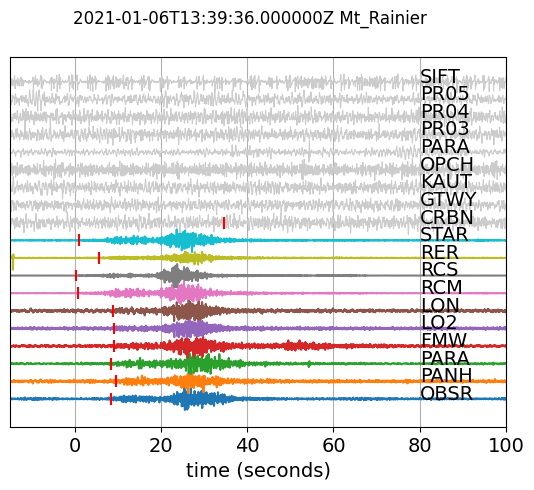

UW RCM
reference time:  2021-01-07T13:38:46.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'RUSH' 'FMW' 'LO2' 'LON' 'RCM' 'RCS' 'RER' 'STAR']
[2.375 1.85  1.5   3.675 4.3   3.65  4.05  0.575 1.075 1.825 1.375]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[  0.      0.      7.825  17.9   -18.325   0.      0.      0.      0.   ]
Plotted


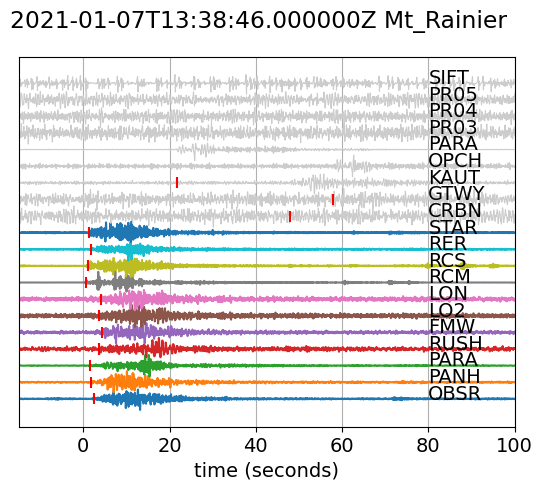

UW STAR
reference time:  2021-01-07T14:48:22.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'FMW' 'LO2' 'LON' 'RCM' 'RCS' 'RER' 'STAR']
[ 0.7    1.25   0.825  1.775  2.625 -3.35   0.325 -0.15   0.475 -0.55 ]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[  0.     13.475   9.025   0.    -12.05   16.425   0.      2.275   0.   ]
Plotted


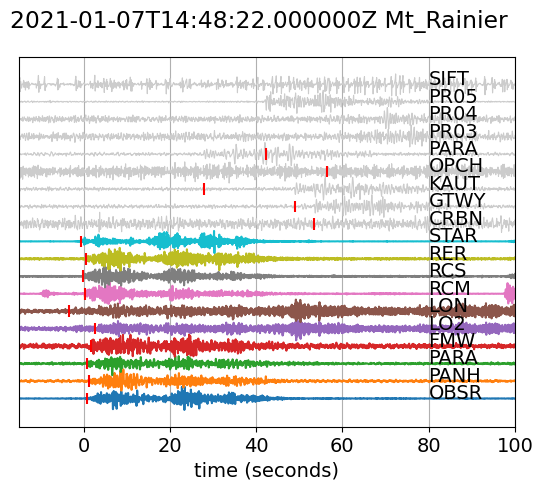

UW STAR
reference time:  2021-01-09T10:20:52.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'PR04' 'PR05' 'RUSH' 'SIFT' 'VOIT' 'FMW' 'LO2' 'LON'
 'RCM' 'RCS' 'RER' 'RVC' 'STAR']
[ 1.325  1.85   1.025  8.35   4.425  7.325  5.05   8.25   4.425  2.65
  2.175  0.35   0.575  0.825  0.    -0.075]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[  0.     45.1    13.225   0.    -13.075  23.225  48.825   2.55    0.   ]
Plotted


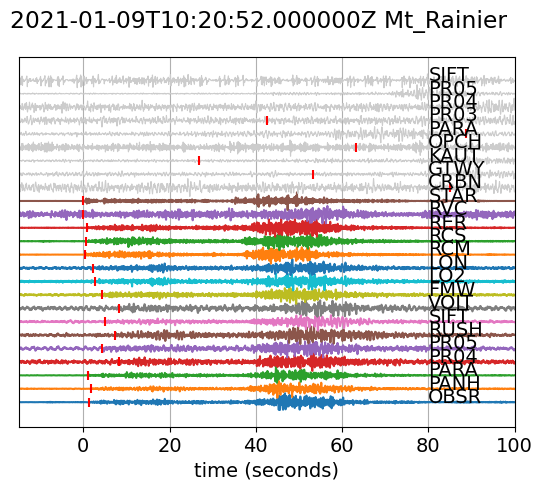

UW RCS
reference time:  2021-01-13T05:32:09.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'PR05' 'RUSH' 'SIFT' 'VOIT' 'FMW' 'LON' 'PCEP' 'RCM'
 'RCS' 'RER']
[ 5.225  4.3    3.65   6.225 -8.975  6.25   5.225  4.3    5.725  0.
  1.475  0.625  3.4  ]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[  0.    0.    0.    0.  -22.5   0.    0.    0.    0. ]
Plotted


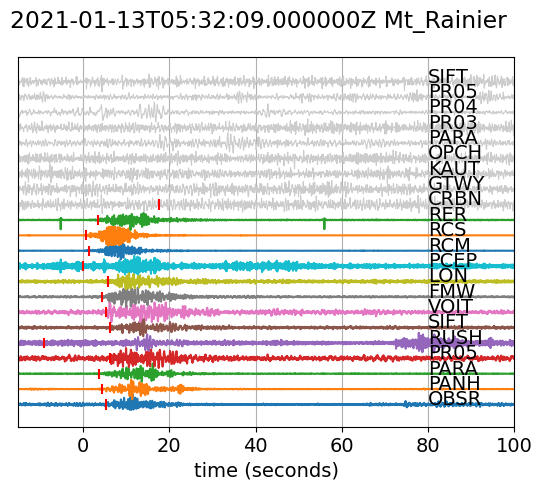

UW RCS
reference time:  2021-01-13T05:37:40.000000Z
relative picks from seismometers
['CARB' 'CRBN' 'GTWY' 'OBSR' 'OPCH' 'PANH' 'PARA' 'PR04' 'PR05' 'RUSH'
 'SIFT' 'VOIT' 'FMW' 'LO2' 'LON' 'PUPY' 'RCM' 'RCS' 'RER']
[-1.55   6.675  8.225  2.975  0.     3.4    3.125  5.675  4.925  7.425
  5.15   5.95   3.45   3.05   3.975  9.975  1.425  0.525  2.075]
relative picks from infrasound
['CRBN' 'GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[ 0.   0.   0.   0.  34.9  0.   0.   0.   0. ]
Plotted


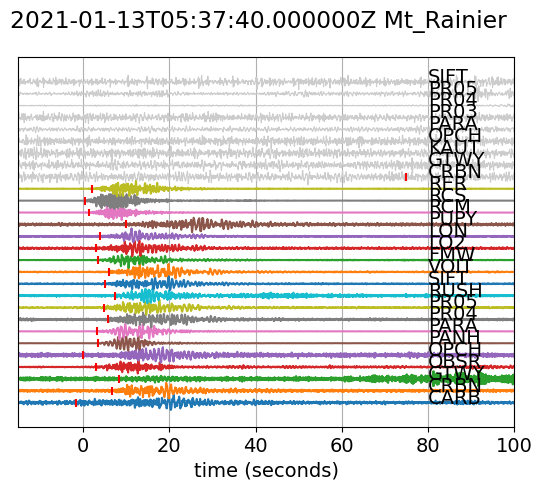

UW RCS
reference time:  2021-01-14T12:21:39.000000Z
relative picks from seismometers
['OBSR' 'PANH' 'PARA' 'PR04' 'FMW' 'RCM' 'RCS' 'RER' 'STAR']
[ 3.5    3.425  3.4   -9.8    2.55   0.35  -0.225  2.125  1.85 ]
relative picks from infrasound
['GTWY' 'KAUT' 'OPCH' 'PARA' 'PR03' 'PR04' 'PR05' 'SIFT']
[0. 0. 0. 0. 0. 0. 0. 0.]
Plotted


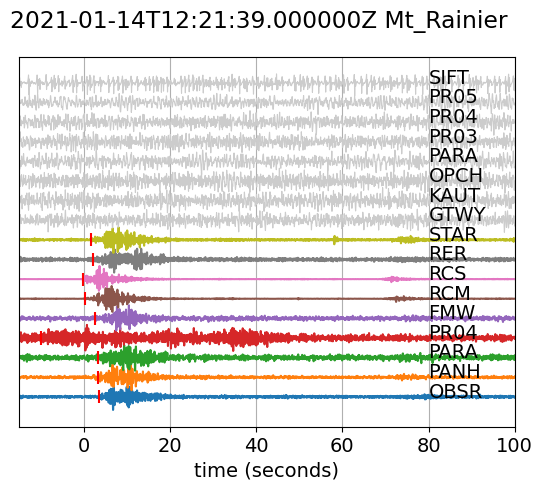

UW RCM


KeyboardInterrupt: 

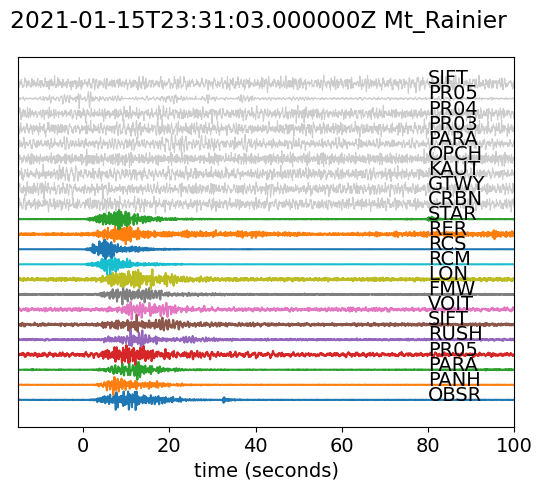

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('../plots/SeisInfra_MtRainier.pdf')
nfigure=0
for n in range(len(evt_id)): 
    if start_time[n]<datetime(2021,1,1):continue  
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    networks=net[n]
    stations=sta[n]
    print(net[n],sta[n])
    if sta[n]=="LON" or sta[n]=="LO2": continue
    try:
        associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
    except:
        pass
    if associated_volcano!="Mt_Rainier":continue            
    # get info for stations within 50km of volcano that event ocurred at
    stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
    networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
    latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
    longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
    elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

    #################### WAVEFORM DOWNLOAD #######################
        #Download all waveforms for that event based on stations and times
    # try:
    bulk=[]
    for m in range(0, len(networks)):
        bulk.append([networks[m], stations[m], '*', '*H*', otime-t_before_raw, otime+t_before_raw])
    st = client2.get_waveforms_bulk(bulk)

    bulk2=[]
    for m in range(0, len(df_infra["Station"])):
        bulk2.append(["CC", df_infra["Station"][m], '01', 'BDF', otime-t_before_raw, otime+t_before_raw])
    infra = client2.get_waveforms_bulk(bulk2)
    #remove unwanted data
    for tr in st:
        cha = tr.stats.channel
        try:
            if len(tr.data)/tr.stats.sampling_rate < 239.9:
                st.remove(tr)
        except:
            pass

    #resampling the data to 40Hz for each trace
    st = resample(st,fs) 
    infra = resample(infra,fs) 

    # #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
    evt_data = obspy.Stream()
    evt_infradata = obspy.Stream()
    SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
    nfigure+=1
    if nfigure<50:
        fig = plt.figure()#figsize = (11,8), dpi=200)
        fig.suptitle(str(otime)+" "+associated_volcano)
        plt.rcParams.update({'font.size': 14})
        ax = plt.subplot(1,1,1)
        iplot = 0
    zz = st.select(component="Z")
    for i,ii in enumerate(zz):
        network = ii.stats.network
        station = ii.stats.station
        ii.detrend(type = 'demean')
        ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
        signal_window = ii.copy()
        noise_window = ii.copy()
        signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
        noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
        if not len(signal_window.data) or not len(signal_window.data): continue
        snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                        / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
        max_amp_time = np.argmax(noise_window.data)/fs
        if snr<thr: 
            st.remove(ii)
            continue
        evt_data.append(signal_window)
        stas.append(ii.stats.station)
        t = signal_window.times()
        if nfigure<50:
            ax.plot(t-t_before,signal_window.data/np.max(np.abs(signal_window.data))+iplot*1.5)
            ax.set_xlabel('time (seconds)')
            ax.set_xlim((-t_before,100))
            ax.set_yticks([])
            plt.text(80, iplot*1.5, station)
            iplot += 1

    sta_available,ind = np.unique(np.array(stas),return_index=True)
    sta_available=sta_available[np.argsort(ind)]
    if len(sta_available)==0:continue
#       Plot the infrasound as well

    evt_infradata = obspy.Stream()
    stas_infra=[]
    for i,ii in enumerate(infra):
        ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut-5,corners=2,zerophase=True)
        signal_window = ii.copy()
        signal_window.trim(otime - t_before, otime - t_before  + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
        if not len(signal_window.data): continue
        t1 = signal_window.times()
        if nfigure<50:
            ax.plot(t1-t_before,signal_window.data/np.max(np.abs(signal_window.data))+iplot*1.5,color='0.8',linewidth=0.8)
            ax.text(80, iplot*1.5, signal_window.stats.station)
            iplot+=1
            ax.set_xlim((-t_before,100))
        evt_infradata.append(signal_window)
        stas_infra.append(ii.stats.station)

    sta_infra_available,ind = np.unique(np.array(stas_infra),return_index=True)
    sta_infra_available=sta_infra_available[np.argsort(ind)]
    if len(sta_infra_available)==0:continue

    # PHASE PICKING
        # test the new function
    smb_peak,smb_peak_mbf = apply_mbf(evt_data, sta_available, \
            list_models, MBF_paras, paras_semblance, t_before,t_around)
    smb_peak_infra,smb_peak_mbf_infra = apply_mbf(evt_infradata, sta_infra_available, \
            list_models, MBF_paras, paras_semblance, t_before+40,t_around+40)

    print("reference time: ",otime)
    print("relative picks from seismometers")
    print(sta_available)
    print(smb_peak_mbf)
    print("relative picks from infrasound")
    print(sta_infra_available)
    print(smb_peak_mbf_infra)

    if nfigure<50:
        iplot=0
        for i in range(len(sta_available)):
            ax.vlines(smb_peak_mbf[i], ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = 'r')
            iplot+=1
        for i in range(len(sta_infra_available)):
            if np.abs(smb_peak_mbf_infra[i])>0.5:
                ax.vlines(smb_peak_mbf_infra[i]+40, ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = 'r')
            iplot+=1

        plt.grid(True)
        pdf.savefig(fig)
        print("Plotted")
        fig.savefig('../plots/waveforms_seismic_infrasound_'+event_ID+associated_volcano+'.png')
        plt.show()
        del fig
        nfigure+=1

    if nfigure==50 :pdf.close()


    

# except:
#     pass




In [ ]:
print(t_before,t_around)
print(t_before+40,t_around+60)

15 10
55 70
